# Field Failure Data Analysis

## Import relevant module

In [ ]:
# Uncomment lines below to install and enable progress bar in JupyterLab
# !pip install tqdm

# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [2]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
from matplotlib import cm

# Reliability
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [3]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in tqdmn(c_wins):
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ
  
            tuples.append(tup)
        
        df_sens = pd.DataFrame(data = {'Window' : c_wins, 'Tuples' : tuples})
        df_sens.to_csv(filepath)

    else:
        print('File already exists!\n')
        df_sens = pd.read_csv(filepath, index_col = 0)
    
    return df_sens      

In [4]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in tqdmn(range(dataframe.shape[0]-1)):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)

    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
    
    return dataframe

In [5]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

## Load Data

In [6]:
df_bgl = pd.read_csv('Dataset/BlueGeneL/BGLErrorLog.txt', names = ['Timestamp', 'ID-Node','Rack', 'Midplane', 'Node', 'Card', 'Card type', 'Message'])

df_bgl.loc[:,'ID-Node'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[1]

df_bgl.loc[:,'Rack'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[0]
df_bgl.loc[:,'Midplane'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[1]
df_bgl.loc[:,'Node'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[2]

df_bgl.loc[:,'Card'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[2]

df_bgl.loc[df_bgl['Card'].str.contains('J18'),'Card type'] = 'I-O'
df_bgl.loc[~df_bgl['Card'].str.contains('J18'),'Card type'] = 'computation'

# df_bgl.loc[:,'Card type'] = df_bgl.loc[:,'Card'].str.split('-', n=1).str[0]

df_bgl.loc[:,'Message'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[3].str.strip()
df_bgl.loc[:,'Timestamp'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_bgl.shape[0]) + ' entries and ' + str(df_bgl.shape[1]) + ' columns.')
df_bgl.head()

c:\users\guido di chiara\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Log file has 125624 entries and 8 columns.


,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,I-O,Lustre mount FAILED : bglio2 : block_id : loca...
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,I-O,Lustre mount FAILED : bglio21 : block_id : loc...
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,I-O,Lustre mount FAILED : bglio124 : block_id : lo...
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio4 : block_id : loca...
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio36 : block_id : loc...


# System (Blue Gene/L)

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



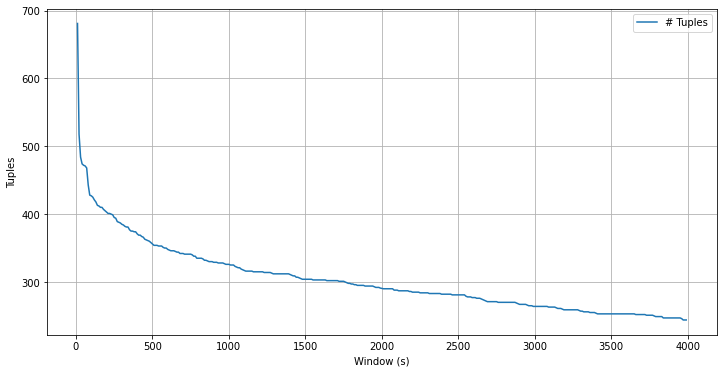

In [7]:
c_wins = np.delete(np.arange(0,4000,10), 0)

filepath = 'Dataset/BlueGeneL/System/BGL-Sensitivity.csv'

df_bgl_sensitivity = sensitivity_analysis(df_bgl, c_wins, filepath)

plt.figure(figsize=(12,6))
plt.plot(df_bgl_sensitivity['Window'],df_bgl_sensitivity['Tuples'], label = '# Tuples')
plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()
plt.savefig("./Images/BGL/BGL_System_Sensitivity.svg", format = "svg")
plt.show()

#### Tupling

In [8]:
window = 500

filepath = 'Dataset/BlueGeneL/System/BGL-Data.csv'

df_bgl = tupling(df_bgl, window, filepath)
df_bgl = df_bgl.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bgl.head()

File already exists!



,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message,Tuple
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,I-O,Lustre mount FAILED : bglio2 : block_id : loc...,0
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,I-O,Lustre mount FAILED : bglio21 : block_id : lo...,0
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,I-O,Lustre mount FAILED : bglio124 : block_id : l...,0
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio4 : block_id : loc...,0
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio36 : block_id : lo...,0


In [9]:
num_tuple = df_bgl.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  356


In [10]:
df_sys_stat = statistics(df_bgl)
df_sys_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,128,1128621350,1128621367,17,7.529412,NaN
1,1024,1128641281,1128641411,130,7.876923,19914.0
2,23,1128702415,1128702464,49,0.469388,61004.0
3,9,1128719240,1128719316,76,0.118421,16776.0
4,14,1128747957,1128748024,67,0.208955,28641.0


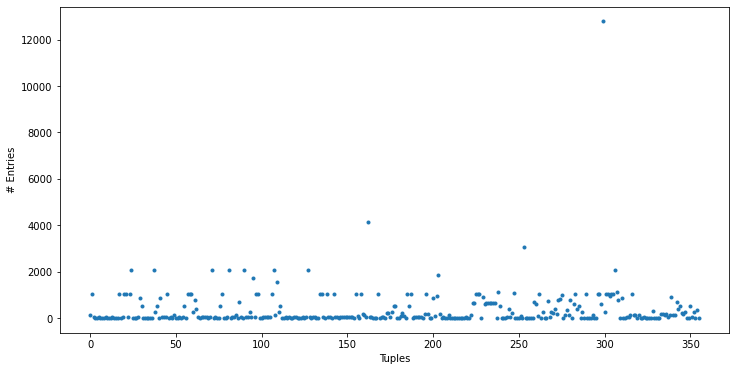

In [11]:
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12,6))
plt.scatter(x, y, marker = '.')
plt.xlabel('Tuples')
plt.ylabel('# Entries')
plt.savefig("./Images/BGL/BGL_System_Scatter_Entry.svg", format = "svg")
plt.show()

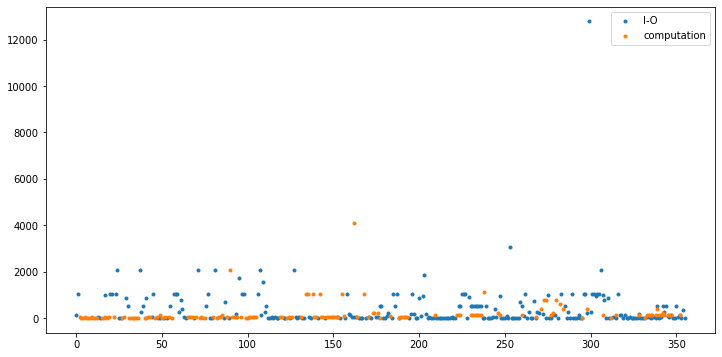

In [12]:
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()

# cmap = cm.get_cmap('tab20')
# colors = cmap.colors

fig, ax = plt.subplots(figsize=(12,6))
# ax.set_prop_cycle(color=colors)

for card in df_bgl['Card type'].unique():
    df_temp = df_group[df_group.index.get_level_values('Card type').isin([card])]
    
    x = df_temp.index.get_level_values(0)
    y = df_temp['Timestamp']
    
    plt.scatter(x,y, label=card, marker = '.')

    
plt.legend()
plt.savefig("./Images/BGL/BGL_System_Scatter_CardType.svg", format = "svg")
plt.show()

### Bottleneck

### Spatial coalescence

### Content-based coalescence

### Truncation analysis

In [13]:
q = df_sys_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 1073.6


In [14]:
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]
df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
7,20,1128801670,1128801722,52,0.384615,828.0
14,1,1128944032,1128944032,0,inf,969.0
21,1024,1129166602,1129166717,115,8.904348,647.0
35,2,1129300645,1129300645,0,inf,851.0
36,2,1129301206,1129301206,0,inf,561.0


In [15]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 36
Estimate percentage of truncations: 10.112359550561797


### Collision analysis

In [16]:
df_group = df_bgl.groupby(by=['Tuple','Rack']).count()
df_group = df_group.reset_index(level = 1)

collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [17]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 177
Estimate percentage of collisions:  49.71910112359551


In [18]:
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()
df_group = df_group.reset_index(level = 1)

collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [19]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 43
Estimate percentage of collisions:  12.07865168539326


In [20]:
# pd.set_option('display.max_rows', 50)

# df_bgl.groupby(by=['Tuple','Rack','Midplane','Node','Card']).count()
# pd.reset_option('display.max_rows')

## Data Analysis

### Empirical time to failure distribution

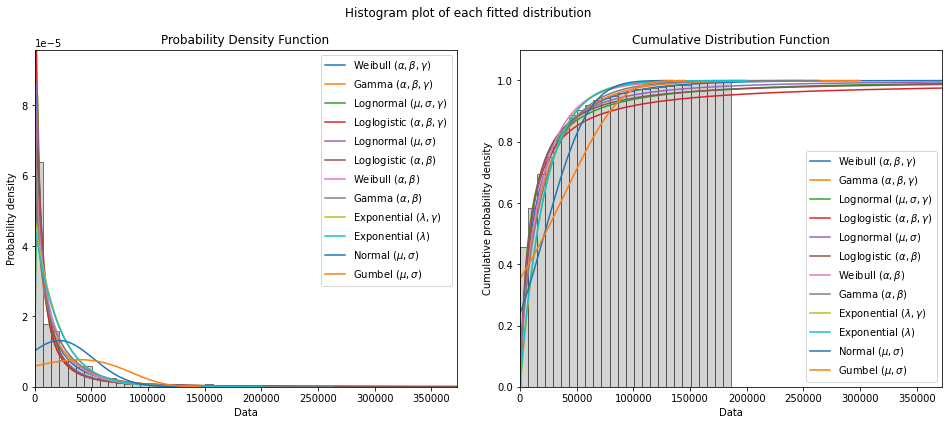

The best fitting distribution was Weibull_3P which had parameters [1.62018413e+04 6.71661886e-01 5.02999900e+02]


In [21]:
data = df_sys_stat['Interarrival'].dropna().to_numpy()

results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

In [22]:
results.results

,Alpha,Beta,Gamma,Mu,Sigma,Lambda,AICc,BIC,AD
Distribution,,,,,,,,,
Weibull_3P,16201.8,0.671662,503,,,,7678.767803,7690.315780,0.409612
Gamma_3P,38593.3,0.550638,503,,,,7682.249980,7693.797958,0.999290
Lognormal_3P,,,421.488,8.92732,1.67661,,7718.829379,7730.377357,2.231110
Loglogistic_3P,8016.17,0.957326,503,,,,7725.206722,7736.754700,2.160633
Lognormal_2P,,,,9.09143,1.45089,,7730.638737,7738.348882,1.911553
Loglogistic_2P,8878.85,1.15471,,,,,7755.494045,7763.204189,2.493192
Weibull_2P,17606.9,0.838365,,,,,7759.648028,7767.358173,4.268847
Gamma_2P,32109,0.677502,,,,,7763.538281,7771.248425,4.012849
Exponential_2P,,,502.999,,,4.70568e-05,7788.584167,7796.294312,27.958509


Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error      Lower CI      Upper CI
Parameter                                                            
Alpha        16201.841255     1347.762937  13764.375163  19070.946333
Beta             0.671662        0.027957      0.619042      0.728754
Gamma          502.999900        0.000174    502.999558    503.000242
Log-Likelihood: -3836.349713243326 



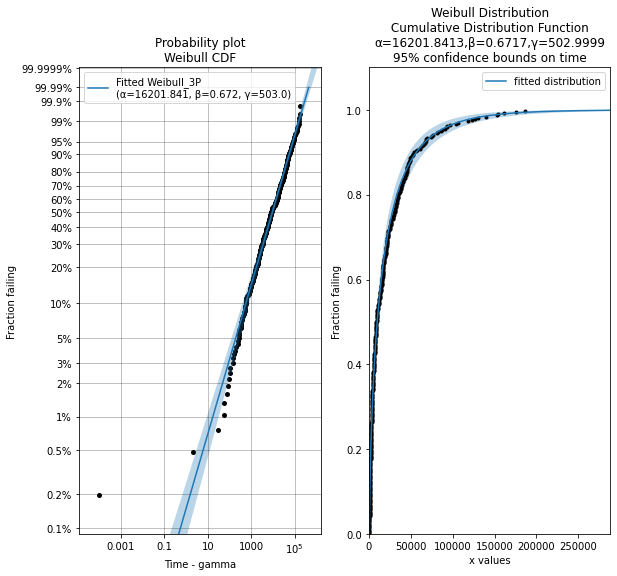

In [23]:
alpha = results.results.loc['Weibull_3P','Alpha']
beta = results.results.loc['Weibull_3P','Beta']
gamma = results.results.loc['Weibull_3P','Gamma']

plt.subplot(121)
fit = Fit_Weibull_3P(failures=data)
plt.subplot(122)
fit.distribution.CDF(label='fitted distribution')
plot_points(failures=data, func='CDF')

plt.legend()
plt.show()

Kolmogorov-Smirnov statistic: 0.027993496341964796
Kolmogorov-Smirnov critical value: 0.07149365187130802
At the 0.05 significance level, we can ACCEPT the hypothesis that the data comes from a Weibull Distribution (α=16201.8413,β=0.6717,γ=502.9999)


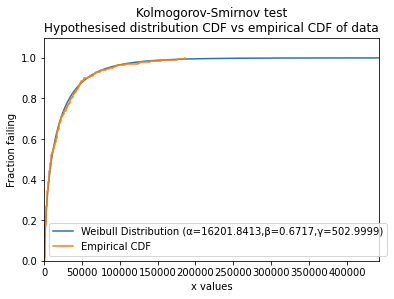

In [24]:
dist = Weibull_Distribution(alpha=alpha, beta=beta, gamma=gamma)

result = KStest(distribution = dist, data = df_sys_stat['Interarrival'].to_numpy(), significance = 0.05)

### Empirical reliability

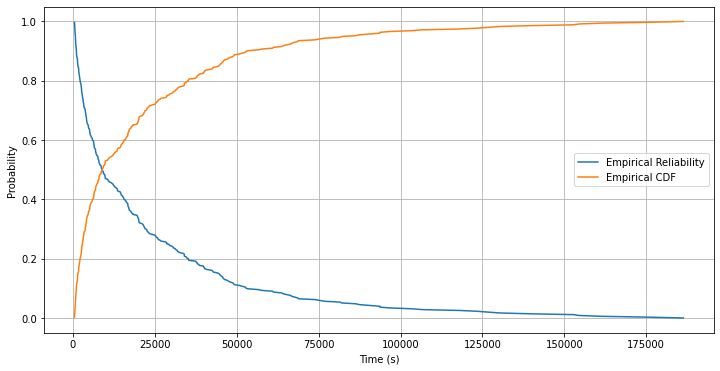

In [25]:
ecdf = ECDF(data)

plt.figure(figsize=(12,6))
    
plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./Images/BGL/BGL_System_Emp_Reliability.svg", format = "svg")
plt.show()

### General analysis

In [26]:
print('Distinct error messages:', df_bgl.groupby(by='Message').count().shape[0])

Distinct error messages: 25712


In [27]:
df_bgl.insert(len(df_bgl.columns), 'Message type', np.NaN)

In [28]:
df_bgl.loc[df_bgl.Message.str.contains('socket') & df_bgl['Message type'].isnull(), 'Message type'] = 'NET'
df_bgl.loc[df_bgl.Message.str.contains('packet') & df_bgl['Message type'].isnull(), 'Message type'] = 'NET'
df_bgl.loc[df_bgl.Message.str.contains('Lustre mount') &  df_bgl['Message type'].isnull(), 'Message type'] = 'FS'
df_bgl.loc[df_bgl.Message.str.contains('cache') & df_bgl['Message type'].isnull(), 'Message type'] = 'CACHE'

df_bgl.loc[df_bgl.Message.str.contains('program image') & df_bgl['Message type'].isnull(), 'Message type'] = 'MEM'
df_bgl.loc[df_bgl.Message.str.contains('directory') & df_bgl['Message type'].isnull(), 'Message type'] = 'FS'

df_bgl.loc[df_bgl.Message.str.contains('link') & df_bgl['Message type'].isnull(), 'Message type'] = 'NET'

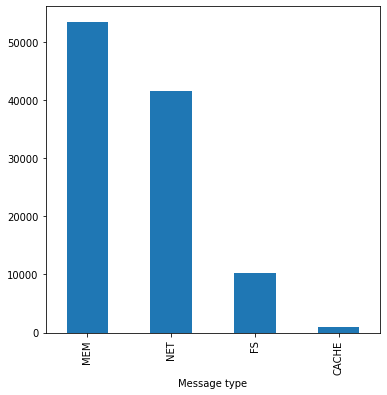

In [29]:
df_bgl.groupby(by='Message type').Timestamp.count().sort_values(ascending=False).plot.bar(figsize=(6,6))
plt.savefig("./Images/BGL/BGL_System_Bar_Message.svg", format = "svg")
plt.show()

In [30]:
df_bgl.loc[df_bgl.Message.str.contains('kernel')].groupby('Message').count()

,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Tuple,Message type
Message,,,,,,,,,
ciod: Error loading /bgl/apps/SWL/functional/SYS_CALLS/testcases/kernel/syscalls/open/dup201: invalid or missing program image,8,8,8,8,8,8,8,8,8
ciod: Error loading /p/gb1/bwallen/oldcode_newkernel.rts: invalid or missing program image,1024,1024,1024,1024,1024,1024,1024,1024,1024
kernel panic,6,6,6,6,6,6,6,6,0
rts: kernel terminated for reason 1004,6144,6144,6144,6144,5760,6144,6144,6144,0
rts: kernel terminated for reason 1007,7,7,7,7,7,7,7,7,0


In [31]:
df_filter = df_bgl.loc[~df_bgl.Message.str.contains('^[0-9]:|^[0-9][0-9]:|^0x')]

df_filter.groupby(by='Message').count().sort_values(by='Timestamp', ascending=False).head(10)

,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Tuple,Message type
Message,,,,,,,,,
Error receiving packet on tree network,6145,6145,6145,6145,5761,6145,6145,6145,6145
rts: kernel terminated for reason 1004,6144,6144,6144,6144,5760,6144,6144,6144,0
ciod: LOGIN chdir(/g/g0/spelce1/Linpack_SWL) failed: No such file or directory,3071,3071,3071,3071,3071,3071,3071,3071,3071
ciod: Error loading /home/spelce1/HPCC_IBM/Urgent/COP/64K/fft_only.rts: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: Error loading /home/spelce1/HPCC_IBM/Urgent/COP/64K/vnm.rts: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: Error loading /bgl/apps/followup/RAPTOR/pre-study/raptor.newcomp.r1: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: Error loading /home/spelce1/HPCC_IBM/Urgent/COP/64K/EPStreamTriad.64K.rts: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: Error loading /g/g0/spelce1/Tuned/SPaSM-base/rundir/SPaSM.baseline: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: LOGIN chdir(RUNS/3Bvn_fmm/rs0000) failed: No such file or directory,1920,1920,1920,1920,1920,1920,1920,1920,1920


# Top Racks

In [32]:
print('Number of racks that generates error: ' + str(len(df_bgl['Rack'].unique())))

Number of racks that generates error: 64


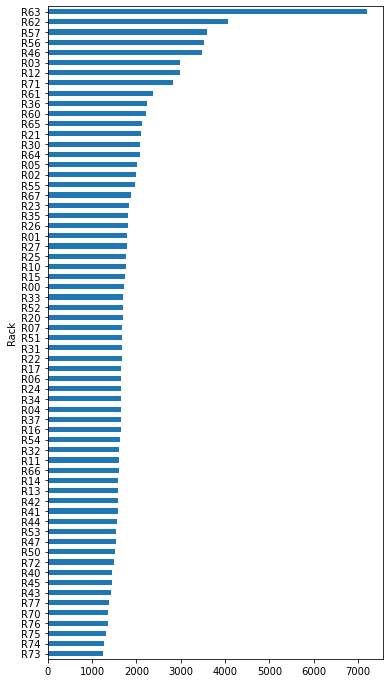

In [33]:
plt.figure(figsize=(6,12))
df_bgl.groupby(by='Rack').Timestamp.count().sort_values().plot.barh()
plt.savefig("./Images/BGL/BGL_System_Bar_Rack.svg", format = "svg")
plt.show()

Il sistema è fatto da 64 rack e gli errori sono distribuiti come nella figura sopra.
sotto si estraggono gli n rack con piu falliemnti, per fare analisi per i rack piu problematici.

In [34]:
n = 8 # l'ho provato per i primi 8 perché c'era roba interessante, pero poi le reliability fanno un po schifo
top_rack = df_bgl.groupby(by=['Rack']).Timestamp.count().sort_values(ascending=False)[0:n].index

df_top_rack = df_bgl.loc[df_bgl['Rack'] == top_rack[0]]
for r in range(1,n):
    df_top_rack = df_top_rack.append(df_bgl.loc[df_bgl['Rack'] == top_rack[r]])

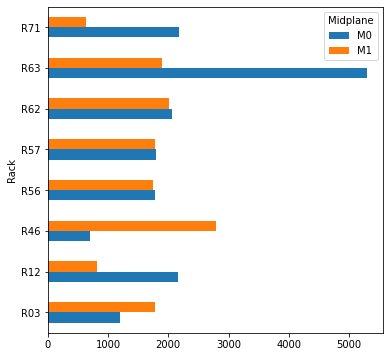

In [35]:
# df_bgl.groupby(by=['Rack', 'Midplane']).Timestamp.count().unstack(1).plot.barh(figsize=(6,15))
df_top_rack.groupby(by=['Rack', 'Midplane']).Timestamp.count().unstack(1).plot.barh(figsize=(6,6))
plt.savefig("./Images/BGL/BGL_Rack_Bar_Rack_Midplane.svg", format = "svg")
plt.show()

ogni rack ha 2 midplane. gli errori trai midplane sono piu o meno bilanciati tranne qualcuno.
il 63 che rompe il cazzo piu di tutti ha un midplain che va a puttane.

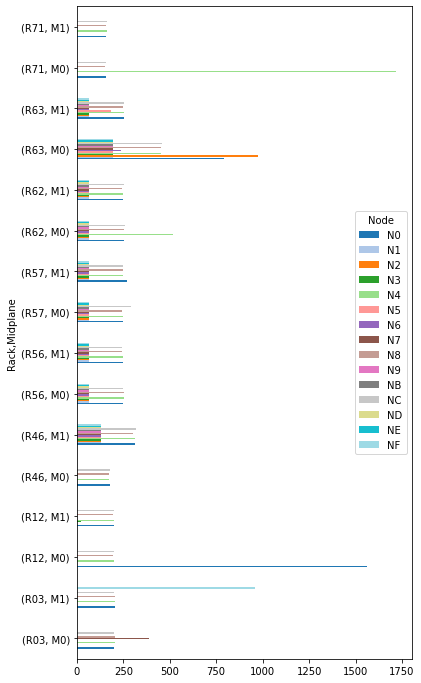

In [36]:
# df_bgl.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2).plot.barh(figsize=(15,35), cmap = 'tab20')
df_top_rack.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2).plot.barh(figsize=(6,12), cmap = 'tab20')
plt.savefig("./Images/BGL/BGL_Rack_Bar_Rack_Midplane_Node.svg", format = "svg")
plt.show()

sicuramente è più leggibile se fatto solo per i top 5 rack, ma cmq si nota che:
- r63 fa cacare un po tutto, non c è un singolo nodo che si sputtana
- r71 ha il nodo con piu fallimenti di tutto il sistema, tipo un N4 che fa IO
- r12 pure non scherza, sempre un nodo di IO (N0)
- r03 pure si rompe un nodo di computation
- tutti i nodi hanno errori sui 4 nodi che hanno scheda di IO (azzurro n0 verde n4 marrone n8 ocra nC)

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [37]:
c_wins = np.delete(np.arange(0,500,1), 0)

for rack in top_rack:
    df_temp = df_bgl.loc[df_bgl['Rack'] == rack]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/BlueGeneL/TopRacks/BGL-' + rack + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



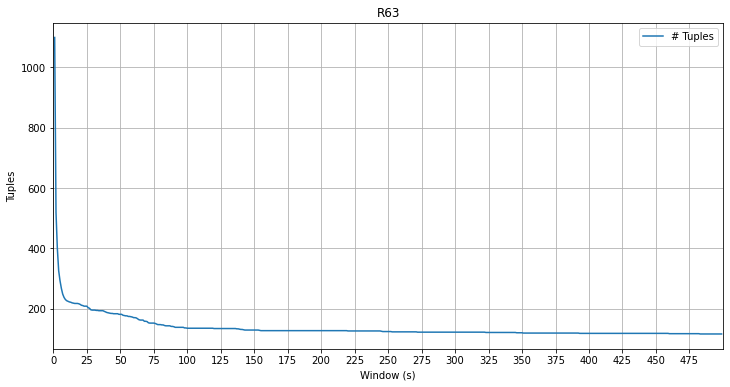

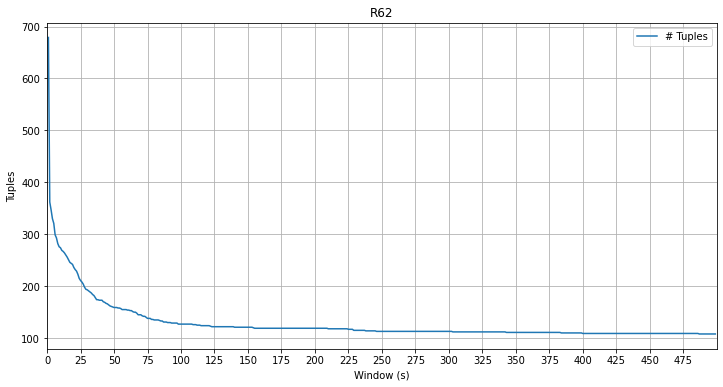

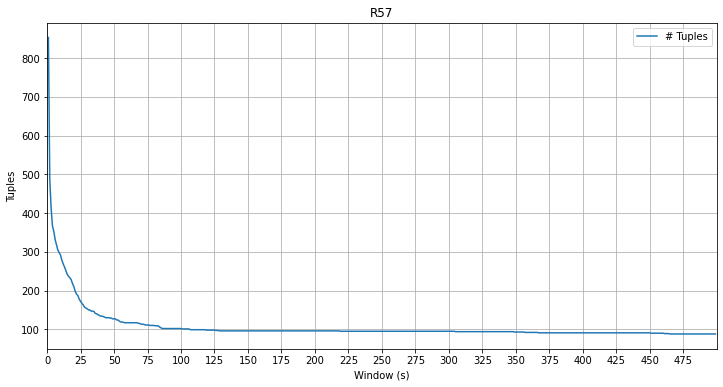

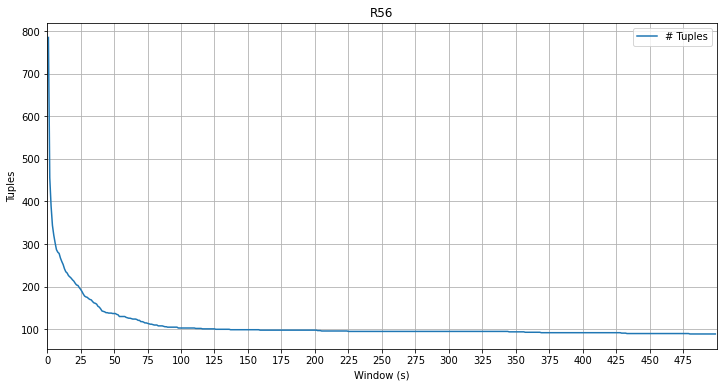

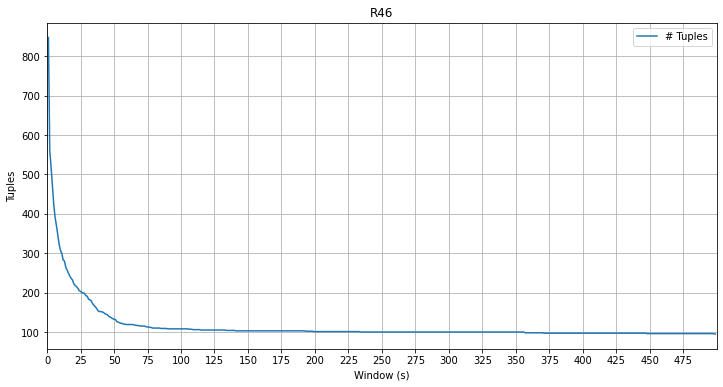

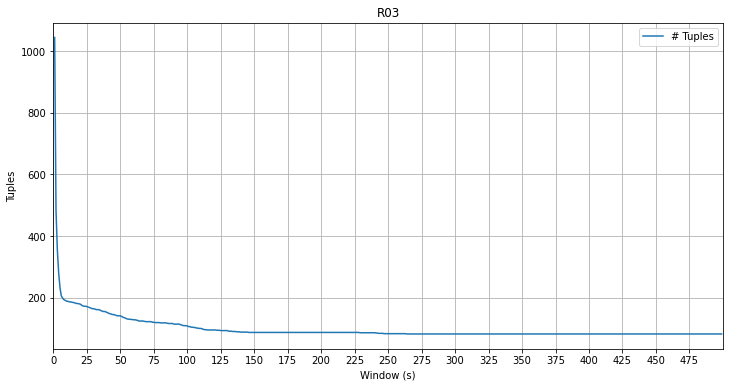

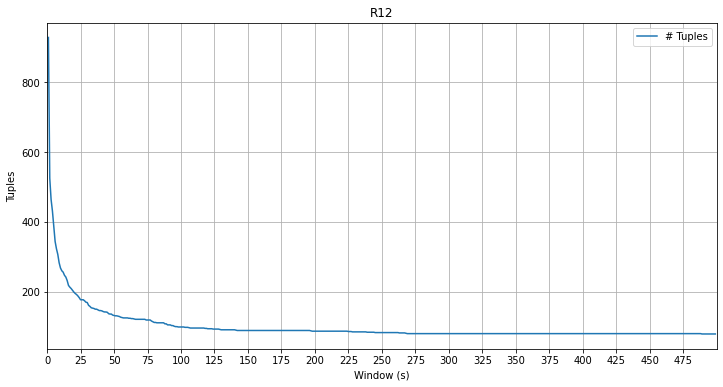

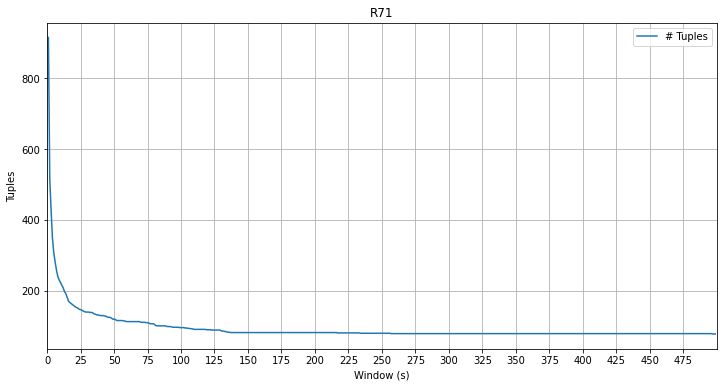

In [63]:
for rack in top_rack:
    filepath = 'Dataset/BlueGeneL/TopRacks/BGL-' + rack + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(rack)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./Images/BGL/BGL_Rack_Sensitivity_" + rack + ".svg", format = "svg")
    plt.show()

In [39]:
win_dict = {'R63' : 75,
            'R62' : 75,
            'R56' : 75,
            'R57' : 75,
            'R46' : 75,
            'R03' : 75,
            'R12' : 75,
            'R71'  : 75}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'R63': 75, 'R62': 75, 'R56': 75, 'R57': 75, 'R46': 75, 'R03': 75, 'R12': 75, 'R71': 75}


#### Tupling

In [40]:
dict_df_rack_stat = {}
dict_rack_num_tup = {}

for rack in top_rack:
    df_temp = df_bgl.loc[df_bgl['Rack'] == rack]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/BlueGeneL/TopRacks/BGL-' + rack + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[rack], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_rack_num_tup[rack] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_rack_stat[rack] = df_stat

print('Number of tuples:', dict_rack_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'R63': 153, 'R62': 138, 'R57': 111, 'R56': 114, 'R46': 113, 'R03': 120, 'R12': 119, 'R71': 109}


## Data Analysis

### Empirical time to failure distribution

Rack: R63


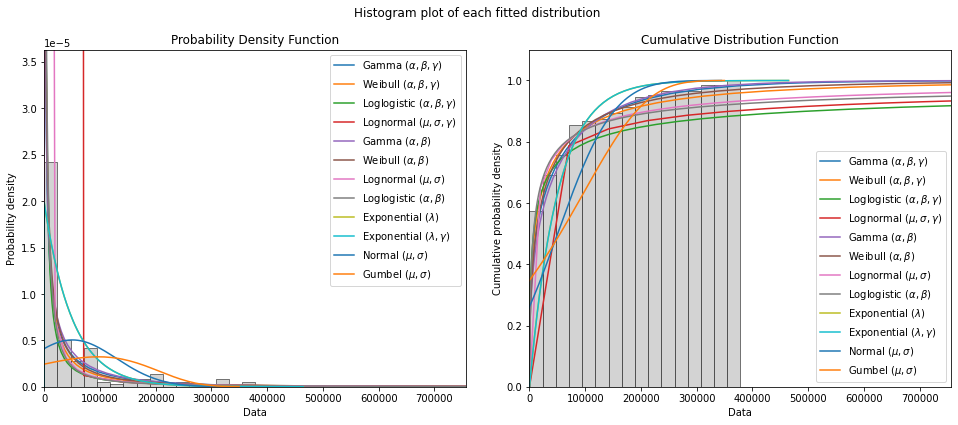

The best fitting distribution was Gamma_3P which had parameters [1.72930861e+05 2.91620958e-01 7.49999000e+01]
Rack: R62


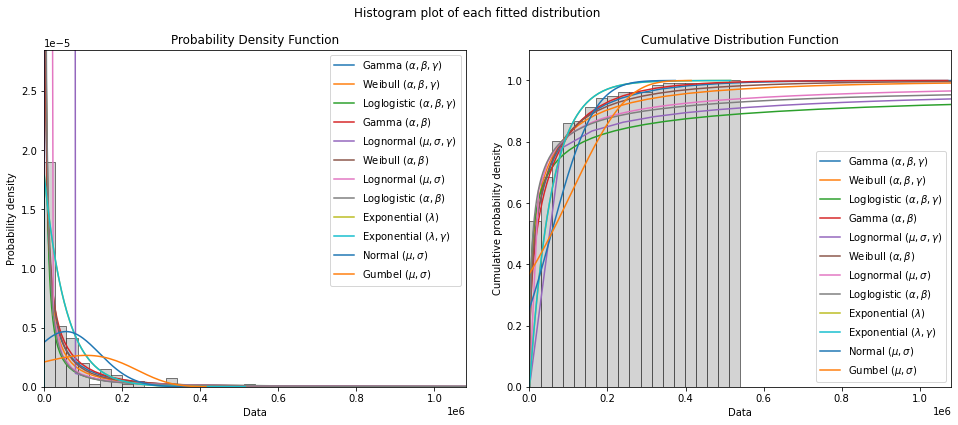

The best fitting distribution was Gamma_3P which had parameters [1.83729285e+05 3.04550348e-01 7.69999000e+01]
Rack: R57


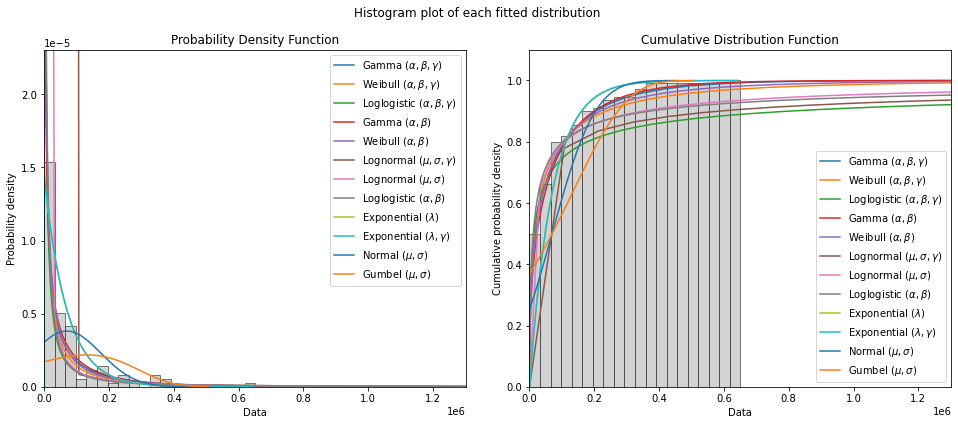

The best fitting distribution was Gamma_3P which had parameters [2.20857538e+05 3.15608139e-01 7.59999000e+01]
Rack: R56


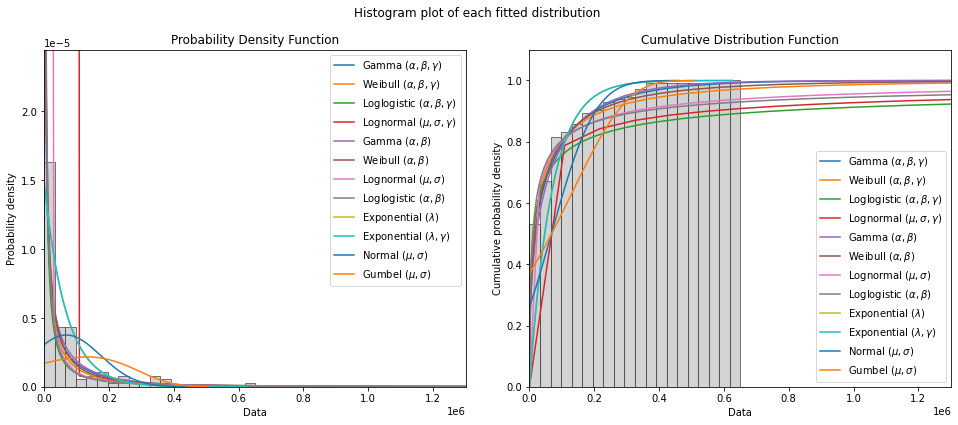

The best fitting distribution was Gamma_3P which had parameters [2.24834170e+05 3.01788955e-01 7.49999000e+01]
Rack: R46


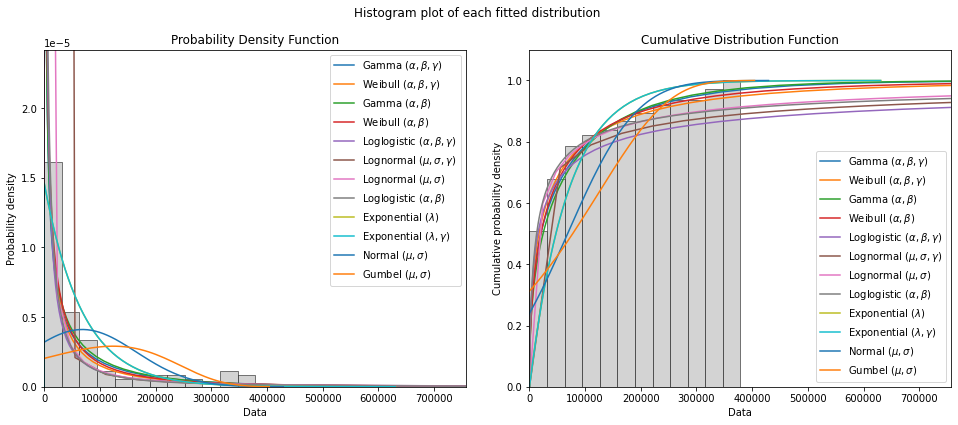

The best fitting distribution was Gamma_3P which had parameters [1.99579619e+05 3.42962707e-01 7.49999000e+01]
Rack: R03


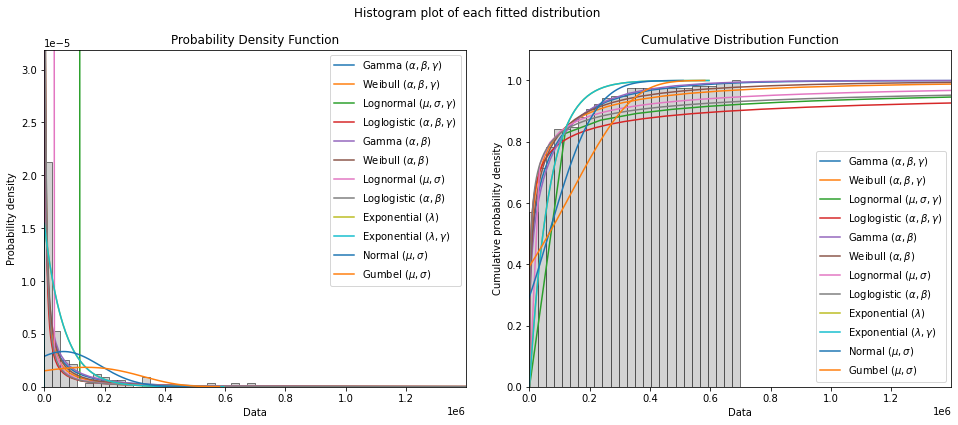

The best fitting distribution was Gamma_3P which had parameters [2.65261208e+05 2.43562365e-01 7.49999000e+01]
Rack: R12


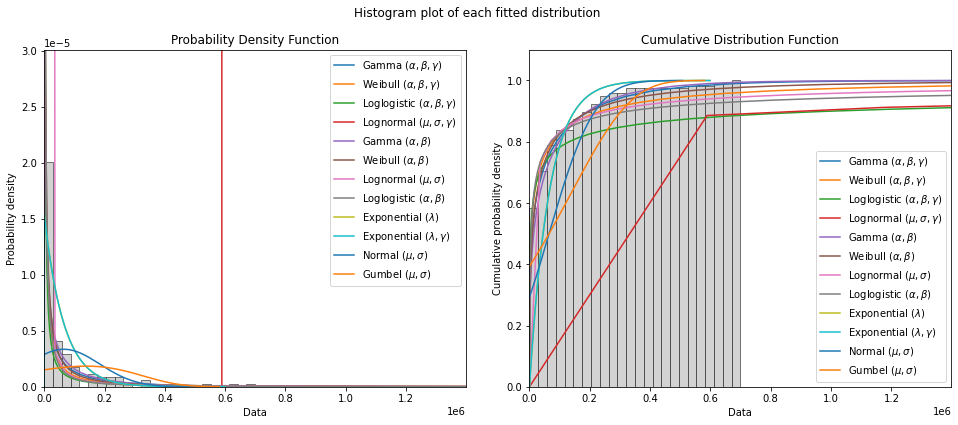

The best fitting distribution was Gamma_3P which had parameters [2.96845548e+05 2.18877565e-01 7.69999000e+01]
Rack: R71


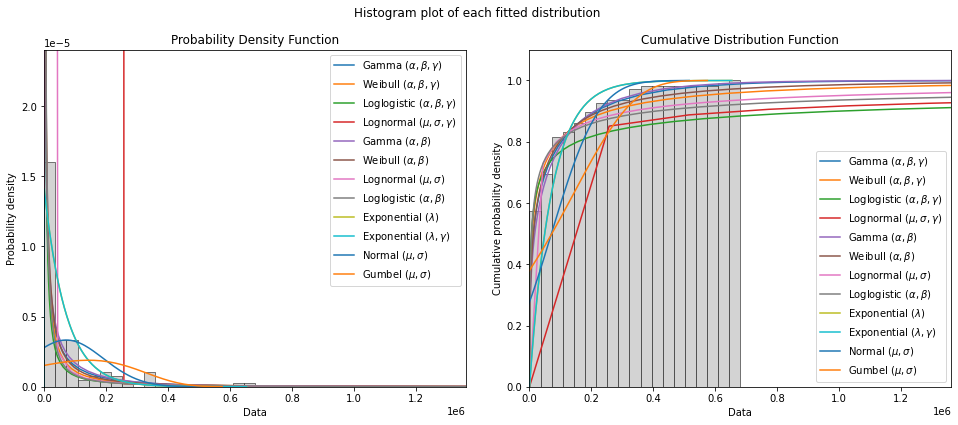

The best fitting distribution was Gamma_3P which had parameters [2.88555086e+05 2.46084954e-01 7.49999000e+01]


In [41]:
for rack in top_rack:
    print('Rack:', rack)
    data = dict_df_rack_stat[rack]['Interarrival'].dropna().to_numpy()
    
    results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
    print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

### Empirical reliability

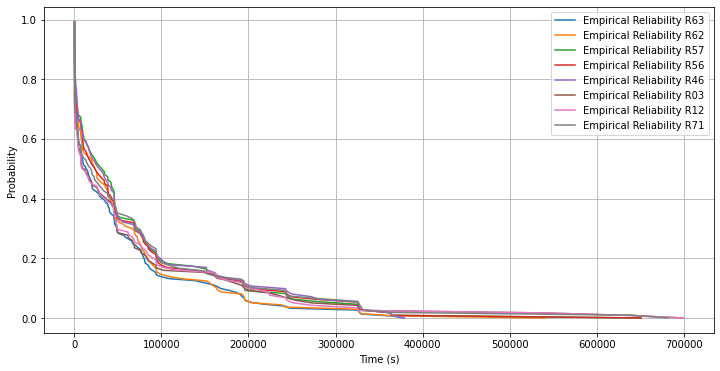

In [65]:
plt.figure(figsize=(12,6))
    
for rack in top_rack:
    ecdf = ECDF(dict_df_rack_stat[rack]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(rack))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./Images/BGL/BGL_Rack_Emp_Reliability.svg", format = "svg")
plt.show()

# Card Types

In [43]:
types = df_bgl['Card type'].unique()

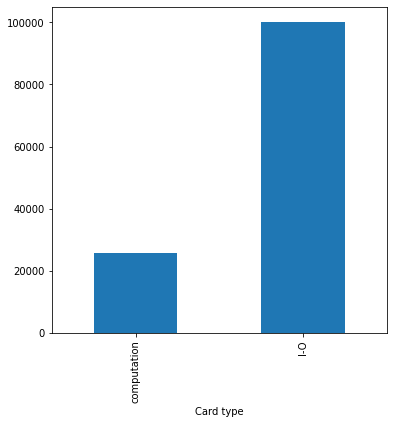

In [44]:
plt.figure(figsize=(6,6))
df_bgl.groupby(by='Card type').Timestamp.count().sort_values().plot.bar(figsize=(6,6))
plt.savefig("./Images/BGL/BGL_Card_Bar_Type.svg", format = "svg")
plt.show()

sopra si vede che fondamentamente ci sono problemi con il sistema di IO.

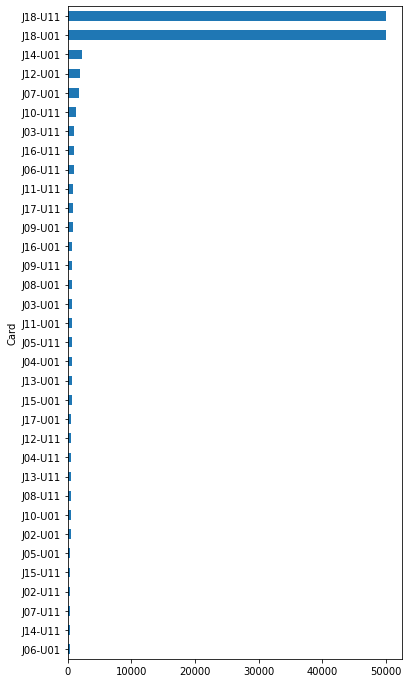

In [45]:
plt.figure(figsize=(6,12))
df_bgl.groupby(by='Card').Timestamp.count().sort_values().plot.barh(figsize=(6,12))
plt.savefig("./Images/BGL/BGL_Card_Bar_Node.svg", format = "svg")
plt.show()

gli errori sono bilanciati tra le due card di ogni tipologia.

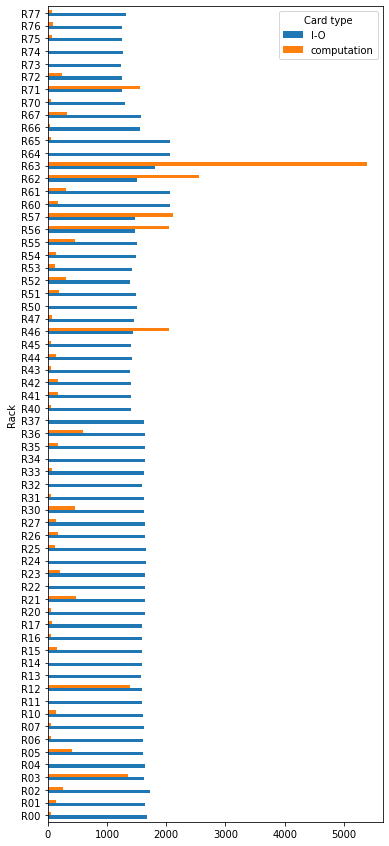

In [46]:
df_bgl.groupby(by=['Rack','Card type']).Timestamp.count().unstack(1).plot.barh(figsize=(6,15))
plt.savefig("./Images/BGL/BGL_Card_Bar_Rack_Type.svg", format = "svg")
plt.show()

da questa immagine vediamo che i problemi di IO sono comuni a quasi tutti i rack.
un altro fatto interessante è che i rack più critici non hanno solo problemi con l'IO ma anche  con le card di computation

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [47]:
c_wins = np.delete(np.arange(0,500,1), 0)

for t in types:
    df_temp = df_bgl.loc[df_bgl['Card type'] == t]
    df_temp.reset_index(drop = True, inplace = True)
    
    filepath = 'Dataset/BlueGeneL/CardTypes/BGL-' + t + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!



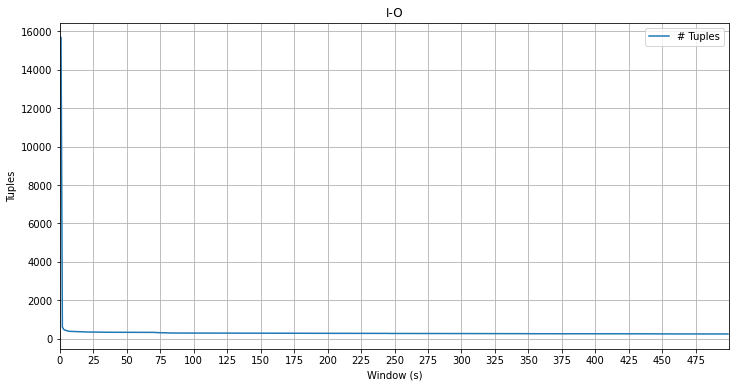

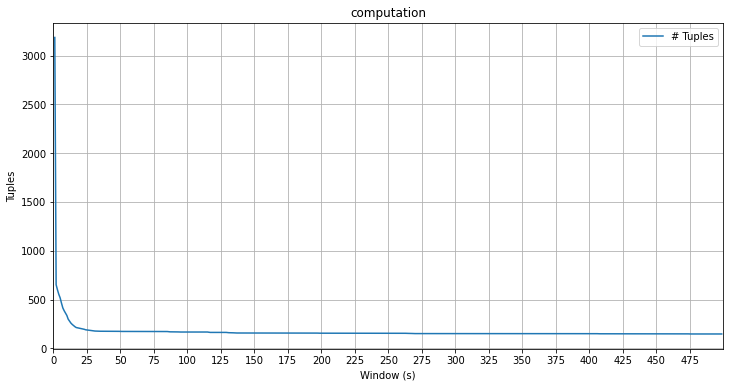

In [48]:
for t in types:
    filepath = 'Dataset/BlueGeneL/CardTypes/BGL-' + t + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(t)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./Images/BGL/BGL_Card_Sensitivity" + t +".svg", format = "svg")
    plt.show()

In [49]:
win_dict = {'I-O' : 10,
            'computation' : 25}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'I-O': 10, 'computation': 25}


#### Tupling

In [50]:
dict_df_type_stat = {}
dict_type_num_tup = {}

for t in types:
    df_temp = df_bgl.loc[df_bgl['Card type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/BlueGeneL/CardTypes/BGL-' + t + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[t], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_type_num_tup[t] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_type_stat[t] = df_stat

print('Number of tuples:', dict_type_num_tup)

File already exists!

File already exists!

Number of tuples: {'I-O': 380, 'computation': 188}


## Data Analysis

### Empirical time to failure distribution

Type: I-O


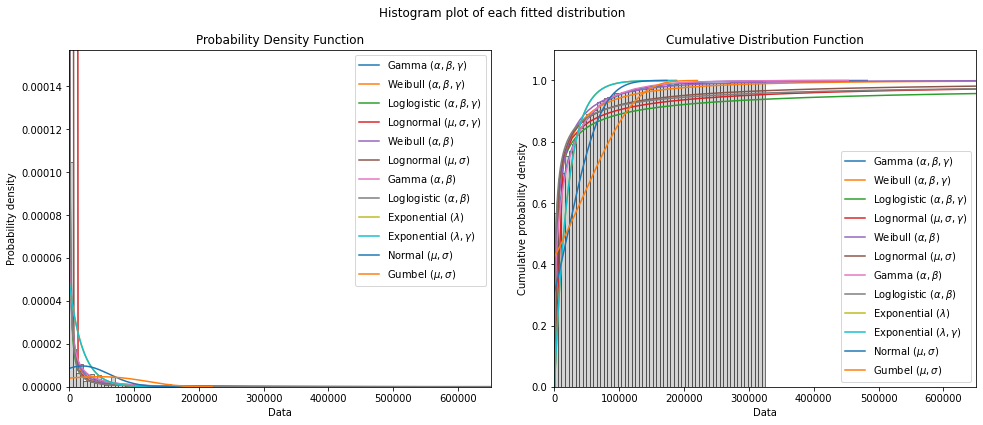

The best fitting distribution was Gamma_3P which had parameters [7.32456558e+04 2.79144565e-01 1.09999000e+01]
Type: computation


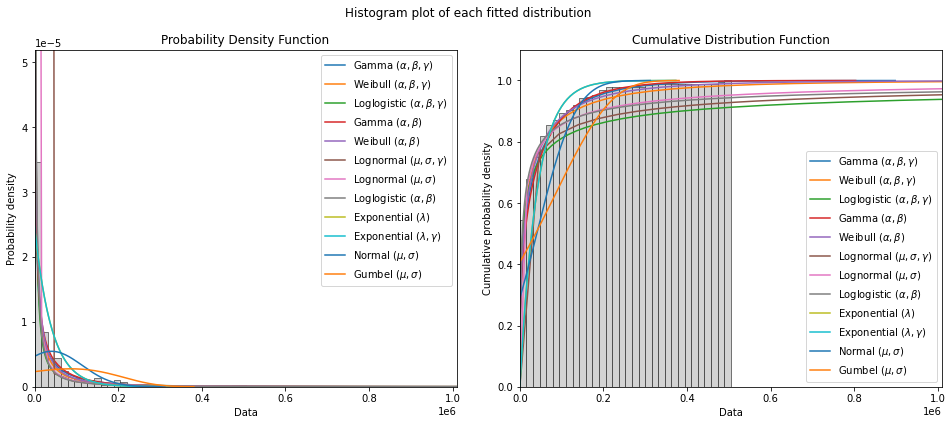

The best fitting distribution was Gamma_3P which had parameters [1.33889391e+05 3.02520724e-01 2.49999000e+01]


In [51]:
for t in types:
    print('Type:', t)
    data = dict_df_type_stat[t]['Interarrival'].dropna().to_numpy()
    
    try:
        results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
        print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)
    except Exception as e:
        print('Exception:', e)

### Empirical reliability

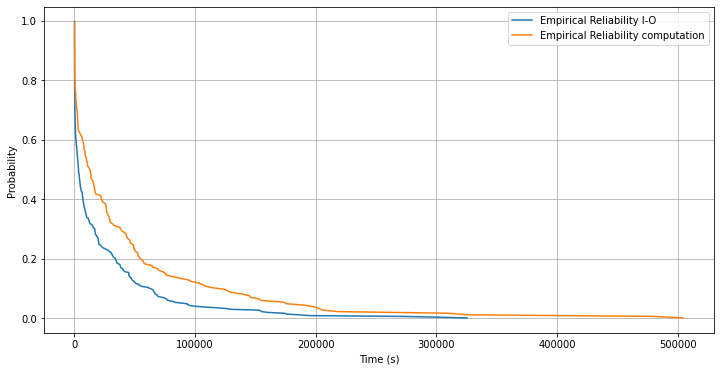

In [52]:
plt.figure(figsize=(12,6))
    
for t in types:
    ecdf = ECDF(dict_df_type_stat[t]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(t))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./Images/BGL/BGL_Card_Emp_Reliability.svg", format = "svg")
plt.show()

# Top Nodes

In [53]:
print('Number of nodes that generates error: ' + str(len(df_bgl['ID-Node'].unique())))

Number of nodes that generates error: 698


In [54]:
n = 5

top_node = df_bgl.groupby(by=['ID-Node']).Timestamp.count().sort_values(ascending=False)[0:n].index

df_top_node = df_bgl.loc[df_bgl['ID-Node'] == top_node[0]]
for r in range(1,n):
    df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])

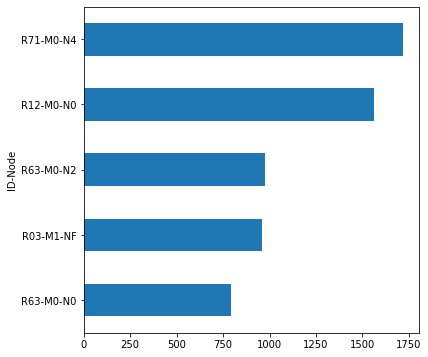

In [55]:
df_top_node.groupby(by='ID-Node').Timestamp.count().sort_values(ascending=True).plot.barh(figsize=(6,6))
plt.savefig("./Images/BGL/BGL_Node_Bar.svg", format = "svg")
plt.show()

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [56]:
c_wins = np.delete(np.arange(0,500,1), 0)

for node in top_node:
    df_temp = df_bgl.loc[df_bgl['ID-Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/BlueGeneL/TopNodes/BGL-' + node + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



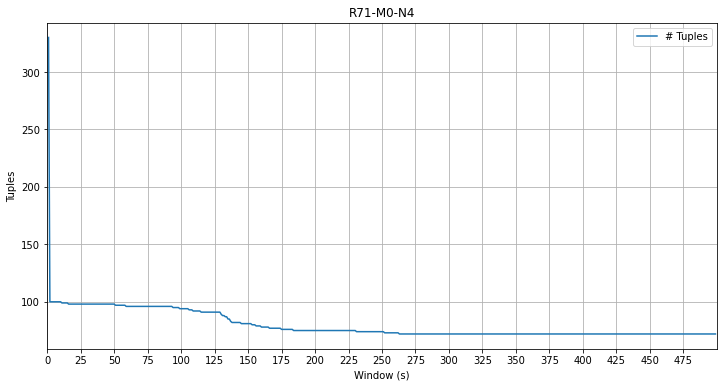

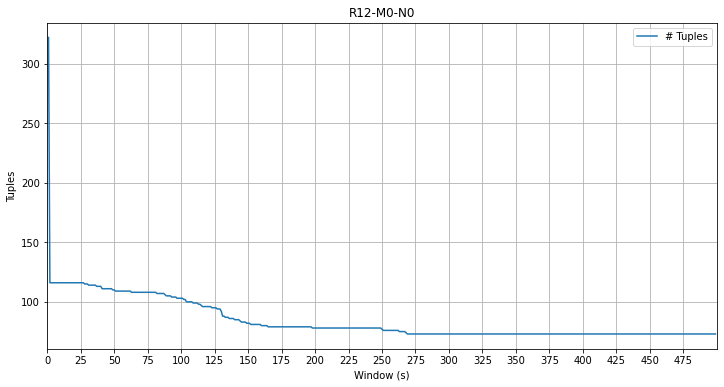

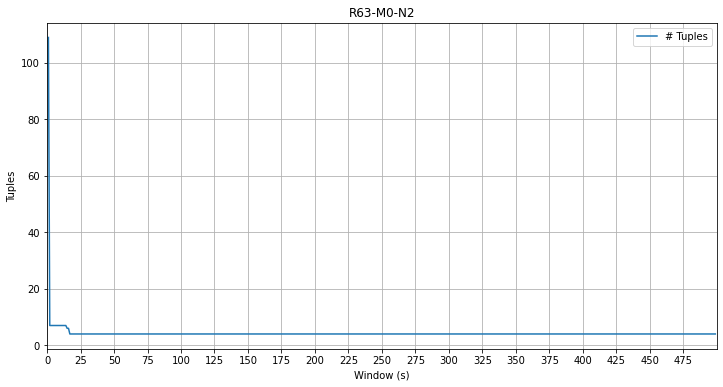

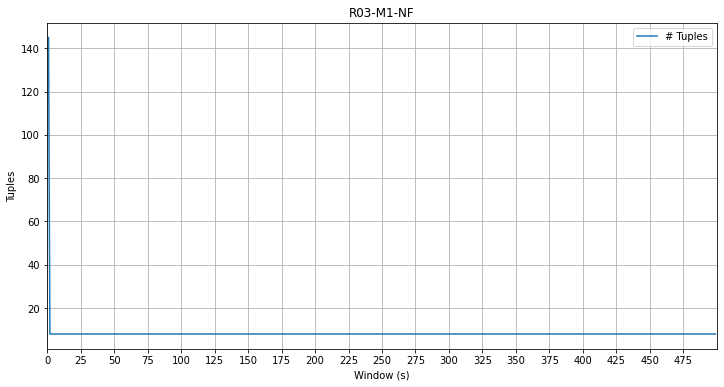

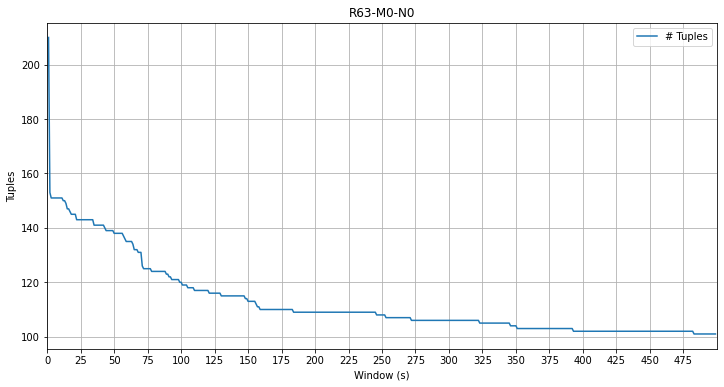

In [57]:
# x_dict = {'tg-c401' : 500,
#           'tg-master' : 500,
#           'tg-c572' : 500,
#           'tg-s044' : 500,
#           'tg-c238' : 500}

for node in top_node:
    filepath = 'Dataset/BlueGeneL/TopNodes/BGL-' + node + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(node)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./Images/BGL/BGL_Node_Sensitivity" + node +".svg", format = "svg")
    plt.show()

In [58]:
win_dict = {'R71-M0-N4' : 175,
            'R12-M0-N0' : 175,
            'R63-M0-N2' : 20,
            'R03-M1-NF' : 5,
            'R63-M0-N0' : 175}

print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'R71-M0-N4': 175, 'R12-M0-N0': 175, 'R63-M0-N2': 20, 'R03-M1-NF': 5, 'R63-M0-N0': 175}


#### Tupling

In [59]:
dict_df_node_stat = {}
dict_node_num_tup = {}

for node in top_node:
    df_temp = df_bgl.loc[df_bgl['ID-Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/BlueGeneL/TopNodes/BGL-' + node + '-Data.csv'
   
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_node_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_node_stat[node] = df_stat
    
print('Number of tuples:', dict_node_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'R71-M0-N4': 76, 'R12-M0-N0': 79, 'R63-M0-N2': 4, 'R03-M1-NF': 8, 'R63-M0-N0': 110}


## Data Analysis

### Empirical time to failure distribution

Node: R71-M0-N4


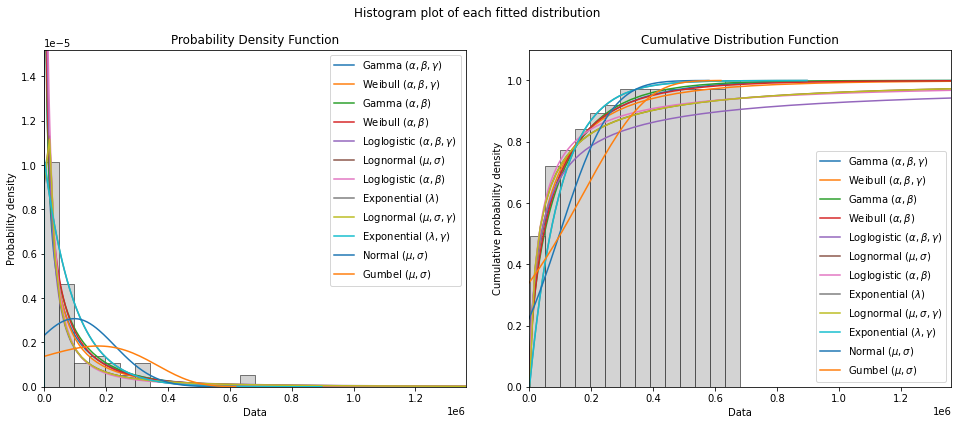

The best fitting distribution was Gamma_3P which had parameters [2.10512640e+05 4.62315233e-01 1.82999900e+02]
Node: R12-M0-N0


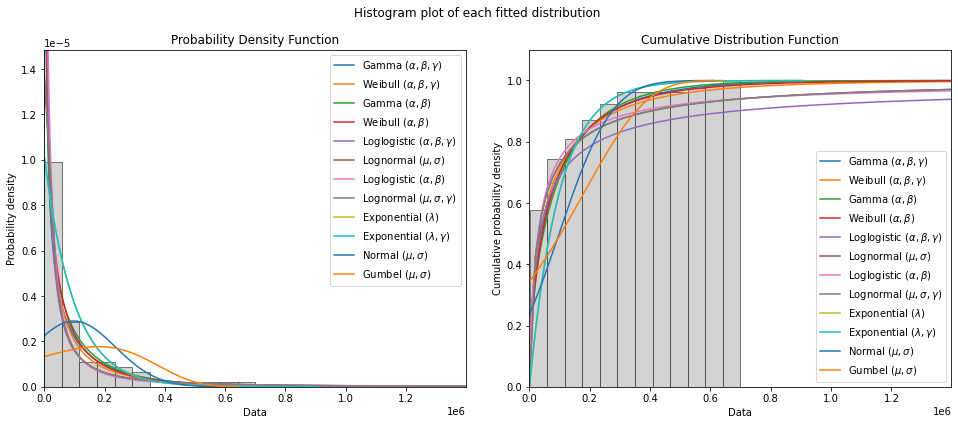

The best fitting distribution was Gamma_3P which had parameters [2.29529347e+05 4.27953600e-01 1.96999900e+02]
Node: R63-M0-N0


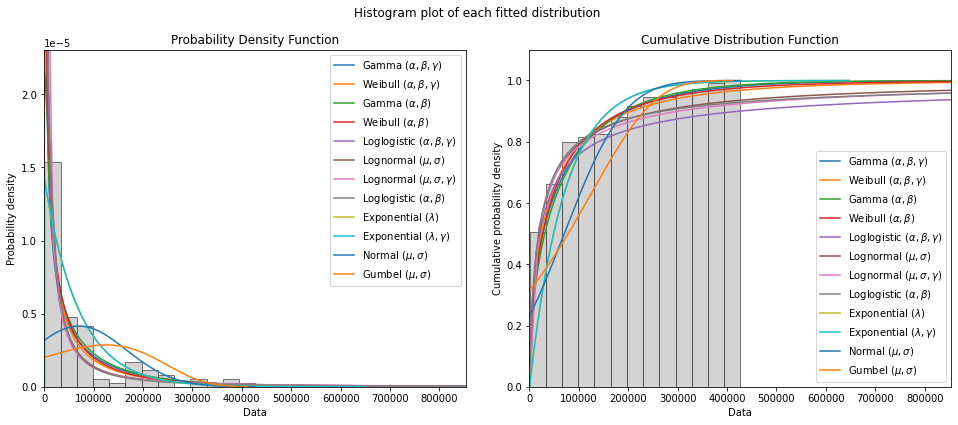

The best fitting distribution was Gamma_3P which had parameters [1.6740860e+05 4.1969088e-01 1.8299990e+02]


In [60]:
top_tup_node = [k for k in dict_node_num_tup if dict_node_num_tup[k] > 30]

for node in top_tup_node:
    print('Node:', node)
    data = dict_df_node_stat[node]['Interarrival'].dropna().to_numpy()
    
    results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
    print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

### Empirical reliability

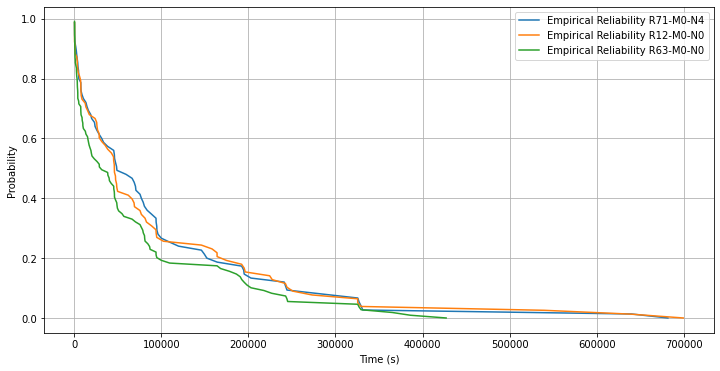

In [61]:
plt.figure(figsize=(12,6))
    
for node in top_tup_node:
    ecdf = ECDF(dict_df_node_stat[node]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(node))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("./Images/BGL/BGL_Node_Emp_Reliability.svg", format = "svg")
plt.show()

# Bottleneck

### Temporal coalescence

#### Sensitivity analysis

In [62]:
c_wins = np.delete(np.arange(0,500,1), 0)

filepath = 'Dataset/Mercury/Bottleneck/Mercury-bottleneck-Sensitivity.csv'

df_bottleneck.reset_index(drop = True, inplace = True)
df_bottleneck_sensitivity = sensitivity_analysis(df_bottleneck, c_wins, filepath)

plt.figure(figsize=(10,6))

plt.plot(df_bottleneck_sensitivity['Window'], df_bottleneck_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

NameError: name 'df_bottleneck' is not defined

#### Tupling

In [ ]:
window = 200
filepath = 'Dataset/Mercury/Bottleneck/Mercury-bottleneck-Data.csv'

df_bottleneck = tupling(df_bottleneck, window, filepath)
df_bottleneck = df_bottleneck.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bottleneck.head()

In [ ]:
num_tuple = df_bottleneck.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

In [ ]:
df_bottleneck_stat = statistics(df_bottleneck)
df_bottleneck_stat.head()

## Bottleneck

### Empirical time to failure distribution

In [ ]:
data = df_bottleneck_stat['Interarrival'].dropna().to_numpy()
   
results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

### Empirical reliability

In [ ]:
ecdf = ECDF(df_bottleneck_stat['Interarrival'].dropna())

plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')
plt.title('Bottlneck (tg-c401)')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

### General Analysis

In [ ]:
df_bottleneck.groupby(by='Subsystem').Timestamp.count().plot.barh()
plt.show()

In [ ]:
df_bottleneck.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple'])

In [ ]:
# risolvere truncation e collision
# clustering